In [1]:
# Generate random colormap:
def rand_cmap(nlabels, type='soft', rnd_seed=123):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :return: colormap for matplotlib
    """
    from colorsys import hsv_to_rgb
    from numpy.random import seed, uniform
    seed(rnd_seed)

    # Generate color map for bright colors, based on hsv:
    if type == 'bright':
        HSVcolors = [(uniform(low=0.0, high=1),
                      uniform(low=0.2, high=1),
                      uniform(low=0.9, high=1)) for _ in range(nlabels)]

        # Convert HSV list to RGB:
        return [*map(lambda c: hsv_to_rgb(*c), HSVcolors)]

    # Generate soft pastel colors, by limiting the RGB spectrum:
    elif type == 'soft':
        low, high = 0.6, 0.95
        return [(uniform(low=low, high=high),
                 uniform(low=low, high=high),
                 uniform(low=low, high=high)) for _ in range(nlabels)]

In [2]:
import json
import pandas as pd


with open('./result.json') as file:
    json_data = json.load(file)
    data = pd.json_normalize(json_data)
    
with open('./config.json') as file:
    config = json.load(file)
    repeat = config['repeat']
    config = config['graph']

In [3]:
values = (config['type'], config['config'], config['files'])
mask = tuple(v not in ['.+', '.*'] for v in values)  # Which value is restricted
reg = '%s\.%s\.files\.%s' % values
filtered = data.filter(regex=reg).iloc[0]

In [4]:
from itertools import cycle


def key_handler(k):
    fpart = k.split()[0]
    return int(fpart) if fpart.isdigit() else -1


def make_bars(ax, df, width, space, mask, values, colors):
    xticklabels = set()
    legend = set()
    for i in map(str.split, df.index, cycle('.')):
        xticklabels.add(i[-2])
        legend.add(i[mask[0]])
    xticklabels = sorted(xticklabels)
    legend = sorted(legend, key=key_handler)

    ind = (1 + space) * np.arange(len(xticklabels))
    rects = []
    if mask[0]:
        reg = '{v}\.{{}}\.files\.{{}}'.format(v=values[0])
    elif mask[1]:
        reg = '{{}}\.{v}\.files\.{{}}'.format(v=values[1])
    else:
        raise Exception('Invalid mask.')

    for i, l in enumerate(legend):
        means = []
        std = []
        for xtl in xticklabels:
            times = df.filter(regex=reg.format(l, xtl)).iloc[0]
            means.append(np.mean(times))
            # std.append(np.std(times))
        rects.append(ax.bar(ind + i * width, means, width, color=colors[i]))  # , yerr=std))

    return xticklabels, legend, ind, rects

In [5]:
def autolabel(ax, rect, unit=''):
    for r in rect:
        height = r.get_height()
        ax.text(r.get_x() + r.get_width() / 2, height, '%.1f%s' % (height, unit),
                ha='center', va='bottom')

In [6]:
import numpy as np
import matplotlib as mpl
from cycler import cycler
import matplotlib.pyplot as plt

%matplotlib inline

In [7]:
# print(sorted(plt.style.available))

In [8]:
plt.clf()
plt.rcParams['figure.figsize'] = (11, 7)
plt.style.use('seaborn-whitegrid')
mpl.rcParams.update({'font.size': 18})
colors = rand_cmap(50)

<Figure size 432x288 with 0 Axes>

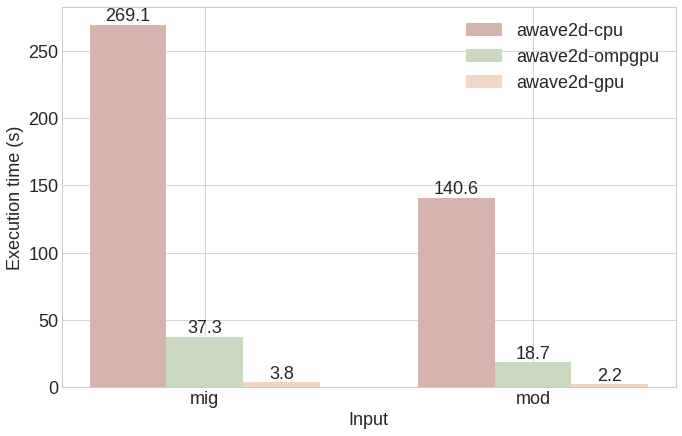

In [9]:
width = 0.35
space = 0.5

fig, ax = plt.subplots()
xticklabels, legend, ind, rects = make_bars(ax, filtered, width, space, mask, values, colors)
ax.set_xlabel('Input')
ax.set_ylabel('Execution time (s)')
ax.set_xticks(ind + len(rects) // 2 * width)
ax.set_xticklabels(xticklabels)
ax.legend((r[0] for r in rects), legend, loc='best')

for rect in rects: autolabel(ax, rect)
    
plt.savefig('./%s/%s.pdf' % (config['folder'], config['name']))

In [10]:
mod_mean, mig_mean = map(np.mean, data.filter(regex='cpu\.default\.files').iloc[0])

In [11]:
other = data.filter(regex='^((?!cpu).)*\.default\.files').iloc[0]  # All but cpu
mod_data, mig_data = other.filter(regex='mod'), other.filter(regex='mig')

mod_speed_up = mod_mean / [*map(np.mean, map(np.array, mod_data))]
mig_speed_up = mig_mean / [*map(np.mean, map(np.array, mig_data))]

name_getter = lambda i: i.split('.')[0]
mod_names, mig_names = [*map(name_getter, mod_data.index)], [*map(name_getter, mig_data.index)]

<Figure size 792x504 with 0 Axes>

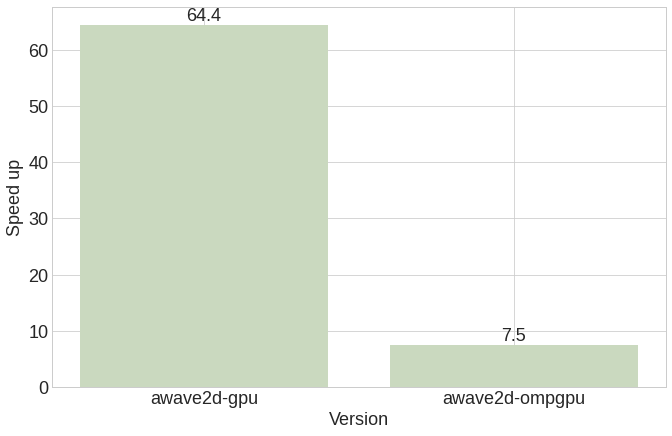

In [12]:
plt.clf()
fig, ax = plt.subplots()

ind = np.arange(len(mod_speed_up))
rect = ax.bar(ind, mod_speed_up, color=colors[1])
ax.set_xlabel('Version')
ax.set_ylabel('Speed up')
plt.xticks(ind, mod_names)
autolabel(ax, rect, unit='')

plt.savefig('./%s/%s.pdf' % (config['folder'], 'mod-speed-up'))

<Figure size 792x504 with 0 Axes>

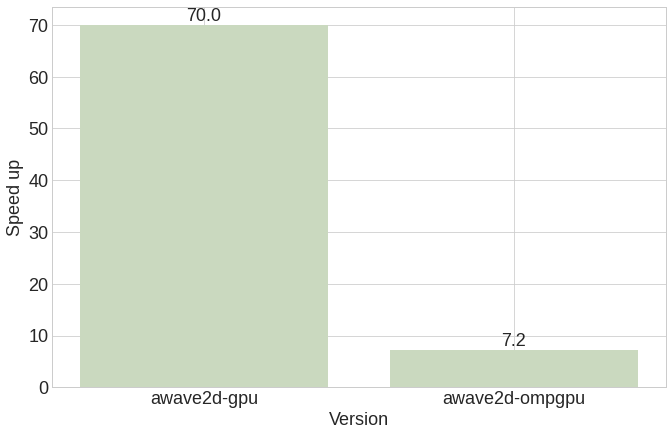

In [13]:
plt.clf()
fig, ax = plt.subplots()

ind = np.arange(len(mig_speed_up))
rect = ax.bar(ind, mig_speed_up, color=colors[1])
ax.set_xlabel('Version')
ax.set_ylabel('Speed up')
plt.xticks(ind, mig_names)
autolabel(ax, rect, unit='')

plt.savefig('./%s/%s.pdf' % (config['folder'], 'mig-speed-up'))

In [14]:
cpu_runs = data.filter(regex='^awave2d-cpu.*\.files').iloc[0]  # All cpu runs
mod_data, mig_data = cpu_runs.filter(regex='mod'), cpu_runs.filter(regex='mig')

mod_speed_up = mod_mean / [*map(np.mean, map(np.array, mod_data))]
mig_speed_up = mig_mean / [*map(np.mean, map(np.array, mig_data))]

plt.rcParams['figure.figsize'] = (6, 6)

<Figure size 432x432 with 0 Axes>

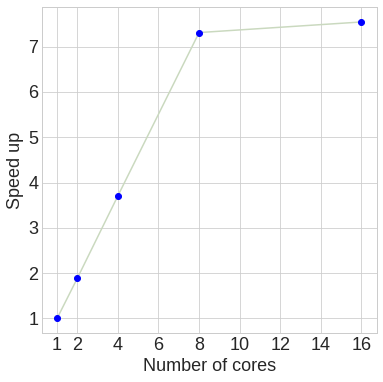

In [15]:
plt.clf()
fig, ax = plt.subplots()

size = len(mod_speed_up)
ind = [2 ** i for i in range(size)]
xticks = [1] + [i for i in range(2, 2 ** (size - 1) + 1, 2)]

ax.plot(ind, mod_speed_up, color=colors[1])
plt.plot(ind, mod_speed_up, 'bo')
ax.set_xlabel('Number of cores')
ax.set_ylabel('Speed up')
plt.xticks(xticks, xticks)

plt.savefig('./%s/%s.pdf' % (config['folder'], 'cpu-mod-speed-up'))

<Figure size 432x432 with 0 Axes>

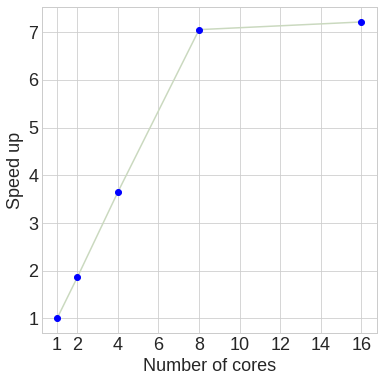

In [16]:
plt.clf()
fig, ax = plt.subplots()

size = len(mig_speed_up)
ind = [2 ** i for i in range(size)]
xticks = [1] + [i for i in range(2, 2 ** (size - 1) + 1, 2)]

ax.plot(ind, mig_speed_up, color=colors[1])
plt.plot(ind, mig_speed_up, 'bo')
ax.set_xlabel('Number of cores')
ax.set_ylabel('Speed up')
plt.xticks(xticks, xticks)

plt.savefig('./%s/%s.pdf' % (config['folder'], 'cpu-mig-speed-up'))